# BERT Training 바로시작

## import libraries for RoBERTa

In [ ]:
!pip install nlp==0.4.0
!pip install transformers
!pip install sentencepiece

import tensorflow as tf
import numpy as np
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import json
import matplotlib.pyplot as plt
import random
import seaborn as sn

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
tqdm.pandas()

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

with open('/gdrive/MyDrive/LG 플젝-민/Sentiment Analysis 작업용/scaling/rating_scaling.pkl', "rb" ) as fr:
    df = pickle.load(fr)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Scaled df

### star to sentiment

In [ ]:
df['scaling'].min()
df['scaling'].max()

10.0

In [ ]:
ver = 1

#### ver1 빡세게

In [ ]:
# # ver1

# neg 012
# neut 34567
# pos  8 9 10


from tqdm import tqdm
tqdm.pandas()



def star2sentiment(star):
  if star < 3: #~3
    return 0
  elif star >= 3 and star <= 7: # 3~7
    return np.nan
  elif star > 7:
    return 1


df['sentiment'] = df['scaling'].progress_apply(lambda star: star2sentiment(star))

100%|██████████| 667628/667628 [00:00<00:00, 680247.67it/s]


In [ ]:
df = df.dropna()
df['sentiment'].value_counts()

1.0    457409
0.0    168703
Name: sentiment, dtype: int64

In [ ]:
df[df['sentiment'].isna()] # 분류 다 됨.

,CreatedTime,Domain,label,source,Star Rating,sent,remove_link_punc,Max rating,Min rating,scaling,sentiment


#### ver2 느슨하게

In [ ]:
# # ver2

# neg 0 1 2 3
# neut 4 5 6
# pos  7 8 9 10


In [ ]:
# from tqdm import tqdm
# tqdm.pandas()



# def star2sentiment(star):
#   if star < 4: #0123
#     return -1
#   elif star >= 4 and star <= 6: # 4~6
#     return 0
#   elif star > 6:
#     return 1


# df['sentiment'] = df['scaling'].progress_apply(lambda star: star2sentiment(star))
# df['sentiment'].value_counts() # ver1이랑 별 차이 없음..

In [ ]:
# df[df['sentiment'].isna()] # 분류 다 됨.

In [ ]:
df['sentiment'] = df['sentiment'].apply(lambda x: int(x))
df['sentiment'].value_counts()

1    457409
0    168703
Name: sentiment, dtype: int64

### sampling for bert 

In [ ]:
# 샘플뽑기용 -  neutral
# d2 = df[df['sentiment'] == 2].sample(40000)
# d0 = df[df['sentiment'] == 0].sample(40000)
# d1 = df[df['sentiment'] == 1].sample(40000)


# d2 = df[df['sentiment'] == 2].sample(1000)
# d0 = df[df['sentiment'] == 0].sample(1000)
# d1 = df[df['sentiment'] == 1].sample(1000)

# d = pd.concat([d0,d1,d2],axis = 0)
# df = d 


#binary
pos_number = 331297 # 50만까지는 작동(총20만)
neg_number = 168703
d0 = df[df['sentiment'] == 0].sample(neg_number)
d1 = df[df['sentiment'] == 1].sample(pos_number)
d = pd.concat([d0,d1],axis = 0)
d = d.sample(pos_number +neg_number)
df = d 


### Text preprocessing

In [ ]:
from tqdm import tqdm
tqdm.pandas()

def lower(sent):
  try:
    return str(sent).lower()
  except:
    print(sent)
df['sent'] = df['sent'].progress_apply(lambda sent: lower(sent))
df['sent'].head()

100%|██████████| 500000/500000 [00:00<00:00, 549726.02it/s]


117156     should only shut off if the left door is opened.
279409    got this one as this has all the features that...
622850                it looks great in the graphite color.
434646                      we are very pleased with dryer.
181045    then you slide the inards back in and mount th...
Name: sent, dtype: object

## EDA

for maxlen

In [ ]:
import re
# removing all everything except a-z english letters # 작동
def engonly(string):  
  string = str(string)
  regex = re.compile('[^a-zA-Z]')
  string = regex.sub(' ', string)
  return string

df['eda_sent'] = df['sent'].apply(lambda string: engonly(string))

In [ ]:
import nltk
nltk.download('punkt')
df['sent']
def tokenize(text):   #Preprocessing
    # tokenize into words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)] 
    return tokens
df['token'] = df['eda_sent'].progress_apply(lambda text: tokenize(text))
df['token']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


  2%|▏         | 9947/626112 [00:01<01:30, 6843.24it/s]


KeyboardInterrupt: ignored

In [ ]:
df['token_len'] = df['token'].apply(lambda x: len(x))
print("median: ",df['token_len'].median())
print("mean: ",df['token_len'].mean())

Text(0, 0.5, 'Number of review')

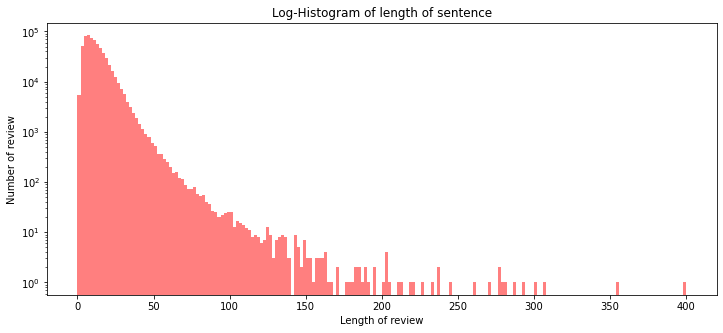

In [ ]:
import matplotlib.pyplot as plt

# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(df['token_len'], bins=200, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of length of sentence')
# 그래프 x 축 라벨
plt.xlabel('Length of review')
# 그래프 y 축 라벨
plt.ylabel('Number of review')

# RoBERTa 구현

참조한 코드:
https://towardsdatascience.com/news-category-classification-fine-tuning-roberta-on-tpus-with-tensorflow-f057c37b093

In [ ]:
df['remove_link_punc']
df['sentiment']

117156    1
279409    1
622850    1
434646    1
181045    1
         ..
646106    1
640284    0
26115     1
74443     1
659085    1
Name: sentiment, Length: 500000, dtype: int64

##Initialize TPU Strategy

In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

batch_size=32 * tpu_strategy.num_replicas_in_sync
print('Batch size:', batch_size)
AUTOTUNE = tf.data.experimental.AUTOTUNE


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.59.142.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.142.42:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Batch size: 256


##Visualize and preprocess data

Let's load the data. We will combine the title and the description into a single string we will use as input for the model. 

Let's explore the data

In [ ]:
n_elements=len(df)
print('Elements in dataset:', n_elements)
n_categories=len(df['sentiment'].unique())
print("{} categories found:".format(n_categories))

Elements in dataset: 500000
2 categories found:


In [ ]:
texts = list(df['remove_link_punc'])
indices = list(df['sentiment'])

In [ ]:
# def indicize_labels(labels):
#     """Transforms string labels into indices"""
#     indices=[]
#     for j in range(len(labels)):
#         for i in range(n_categories):
#             if labels[j]==categories[i]:
#                 indices.append(i)
#     return indices

# indices=indicize_labels(aggregated) #Integer label indices
tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf') #Tokenized text
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), indices)) #Create a tensorflow dataset
#train test split, we use 10% of the data for validation
val_data_size=int(0.1*n_elements)
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

Let's visualize how the tokenizer splits the text into (sub)words and how text gets tokenized.

In [ ]:
# tokens=tokenizer(headlines[0:3], padding=True, truncation=True)['input_ids']
tokens=tokenizer(list(df['remove_link_punc'].iloc[0:3].values), padding=True, truncation=True)['input_ids']
for i in range(3):
  print('Input:',df['remove_link_punc'].iloc[i])
  print('Subword tokenization:',tokenizer.tokenize(df['remove_link_punc'].iloc[i]))
  print('Indices:', tokens[i])


Input: should only shut off if the left door is opened 
Subword tokenization: ['should', 'Ġonly', 'Ġshut', 'Ġoff', 'Ġif', 'Ġthe', 'Ġleft', 'Ġdoor', 'Ġis', 'Ġopened', 'Ġ']
Indices: [0, 17276, 129, 2572, 160, 114, 5, 314, 1883, 16, 1357, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Input: got this one as this has all the features that i need working so far well better than what i was initially hoping 
Subword tokenization: ['got', 'Ġthis', 'Ġone', 'Ġas', 'Ġthis', 'Ġhas', 'Ġall', 'Ġthe', 'Ġfeatures', 'Ġthat', 'Ġi', 'Ġneed', 'Ġworking', 'Ġso', 'Ġfar', 'Ġwell', 'Ġbetter', 'Ġthan', 'Ġwhat', 'Ġi', 'Ġwas', 'Ġinitially', 'Ġhoping', 'Ġ']
Indices: [0, 22371, 42, 65, 25, 42, 34, 70, 5, 1575, 14, 939, 240, 447, 98, 444, 157, 357, 87, 99, 939, 21, 3225, 2818, 1437, 2]
Input: it looks great in the graphite color 
Subword tokenization: ['it', 'Ġlooks', 'Ġgreat', 'Ġin', 'Ġthe', 'Ġgraph', 'ite', 'Ġcolor', 'Ġ']
Indices: [0, 405, 1326, 372, 11, 5, 20992, 1459, 3195, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

We see that the character 'Ġ' is used to indicate the start of a new word in the text, while the other parts of the words that get split don't contain it. For example 'reevaluate' gets split into 'Ġre' and 'evaluate'. We further notice that the tokenize uses the index 0 to indicate the beginning of the text and 2 to indicate the ending. Index 1 is reserved for padding. 

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
1757/1757 [==============================] - 1667s 899ms/step - loss: 0.3071 - sparse_categorical_accuracy: 0.8703 - val_loss: 0.2776 - val_sparse_categorical_accuracy: 0.8892
Epoch 2/8
1757/1757 [==============================] - 1572s 895ms/step - loss: 0.2592 - sparse_categorical_accuracy: 0.8957 - val_loss: 0.2690 - val_sparse_categorical_accuracy: 0.8941
Epoch 3/8
1757/1757 [==============================] - 1572s 895ms/step - loss: 0.2385 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.2666 - val_sparse_categorical_accuracy: 0.8969
Epoch 4/8
1757/1757 [==============================] - 1576s 897ms/step - loss: 0.2211 - sparse_categorical_accuracy: 0.9127 - val_loss: 0.2708 - val_sparse_categorical_accuracy: 0.8968
Epoch 5/8
1757/1757 [==============================] - 1579s 899ms/step - loss: 0.2048 - sparse_categorical_accuracy: 0.9202 - val_loss: 0.2764 - val_sparse_categorical_accuracy: 0.8970


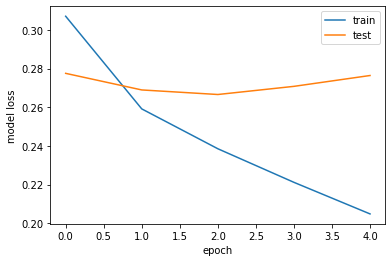

In [ ]:
# Earlystopping이 없어서 추가함. 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy()],
        )

earlystop_callback = EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.0001,patience=2)
history=model.fit(train_ds, validation_data=val_ds, epochs=8, verbose=1,callbacks=[earlystop_callback])

model.save_weights('/gdrive/MyDrive/LG 플젝-민/Sentiment Analysis 작업용/Training/RoBERTa Classifier/'+str(pos_number +neg_number)+'saved_weights.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
# plt.savefig('train_history.png')
plt.show()

In [ ]:
# trained_model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
# trained_model.load_weights('/gdrive/MyDrive/LG 플젝-민/Sentiment Analysis 작업용/Training/RoBERTa Classifier/saved_weights.h5')

In [ ]:
# labels = list(df['sentiment'])

# tokens=tokenizer(texts, padding=True,truncation=True, return_tensors='tf')
# logits=model.predict(dict(tokens), verbose=1).logits
# prob=tf.nn.softmax(logits, axis=1).numpy()
# predictions=np.argmax(prob, axis=1)
# confusion_matrix=tf.math.confusion_matrix(labels, predictions, num_classes=n_categories)


313/313 [==============================] - 9s 28ms/step


Let's visualize the confusion matrix over the validation set. 

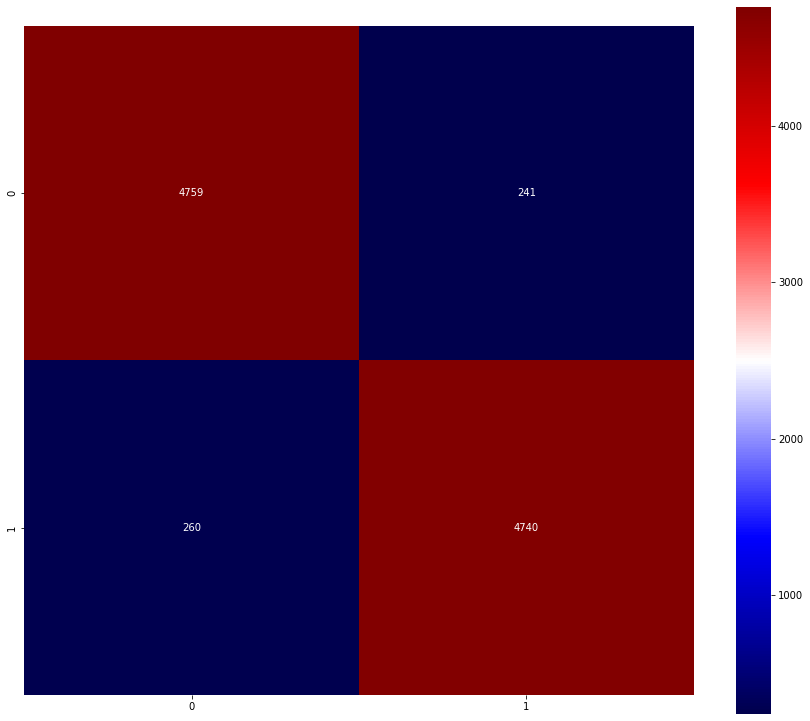

In [ ]:
# categories = [0,1]
# import seaborn as sn
# plt.figure(figsize=(15,13))
# sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='seismic', square=True, xticklabels=categories, yticklabels=categories) 

Let's compute the (weighted) precision, recall and f1 metrics. 

In [ ]:
# precision=metrics.precision_score(labels, predictions, average='weighted')
# recall=metrics.recall_score(labels, predictions, average='weighted')
# f1=metrics.f1_score(labels, predictions, average='weighted')
# print('Precision:{}, Recall:{}, F1 score:{}.'.format(precision, recall, f1))

Precision:0.9499064966498117, Recall:0.9499, F1 score:0.9498998191383471.


Let's visualize some examples and respective top-3 predicted probabilities.

Let's compare the performance of the model when we feed only the headlines without the short description.

# tips for multi-class classification

https://jesusleal.io/2020/10/20/RoBERTA-Text-Classification/

if you expand this to multi-class classification (>2), you can change the compute_metrics function to average='micro'. However, you must also supply the set of label integer values other than 0. For instance, if you have 3 classifications you would change the call to precision_recall_fscore_support to:

precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, labels=[1,2], average='micro')

The fact that EvalPrediction calls the targets to be matched label_ids makes the arguments a bit confusing. It would be better, IMO, to refactor label_ids as targets or y_true.

# =========

# Test set Evaluation 

## load test set

In [ ]:
from tqdm import tqdm
tqdm.pandas()

cols = ['sent_id',	'source',	'original',	'label']
test_df = pd.DataFrame(data = [], columns = cols)
import os
os.chdir('/gdrive/MyDrive/LG 플젝-민/Sentiment Analysis 작업용/Test set/labeled test set')
for excel_file in os.listdir():
  temp_df = pd.read_excel(excel_file,index_col=0)
  test_df = test_df.append(temp_df)

In [ ]:
test_df

,sent_id,source,original,label
0.0,93609,Reddit,i got a case similar to this one which is clea...,0
1.0,16481,Reddit,at that point essentially shut it down and pow...,0
2.0,29473,Reddit,the fridge was the most expensive one and it n...,0
3.0,33560,Reddit,if you look on their support page its clear th...,0
4.0,133183,Reddit,if you cant get a perfect length you can alway...,0
...,...,...,...,...
7994.0,859511.0,Facebook,"Laura Vinson, 4316 Summercrest Blvd Unit 101 A...",-1.0
7995.0,914321.0,Facebook,Buyers beware – I submitted a BBB case on 12/4...,-1.0
7996.0,879633.0,Facebook,"No, I am NOT happy... exchanged it this mornin...",-1.0
7997.0,883021.0,Facebook,I will never buy a Samsung product again. We p...,-1.0


## pre-process test set

In [ ]:
test_df.reset_index(inplace = True,drop = True)
test_df

,sent_id,source,original,label
0,93609,Reddit,i got a case similar to this one which is clea...,0
1,16481,Reddit,at that point essentially shut it down and pow...,0
2,29473,Reddit,the fridge was the most expensive one and it n...,0
3,33560,Reddit,if you look on their support page its clear th...,0
4,133183,Reddit,if you cant get a perfect length you can alway...,0
...,...,...,...,...
9990,859511.0,Facebook,"Laura Vinson, 4316 Summercrest Blvd Unit 101 A...",-1.0
9991,914321.0,Facebook,Buyers beware – I submitted a BBB case on 12/4...,-1.0
9992,879633.0,Facebook,"No, I am NOT happy... exchanged it this mornin...",-1.0
9993,883021.0,Facebook,I will never buy a Samsung product again. We p...,-1.0


In [ ]:
test_df[test_df['label'].isna()]

,sent_id,source,original,label


In [ ]:

# ** 임시. -1도 되면 걍 두기. 안됨.
def temp_label_changer(label):
  label = int(label)
  if label == -1:
    return 0
  # elif label ==0:
  #   return 1 # 중립은 없다..
  elif label ==1:
    return 1

test_df['label'] = test_df['label'].progress_apply(lambda label: temp_label_changer(label))

100%|██████████| 9995/9995 [00:00<00:00, 554590.74it/s]


### binary only

In [ ]:
test_df = test_df[(test_df['label'] == 0)|(test_df['label'] == 1)]
test_df

,sent_id,source,original,label
5,176309,Reddit,as for agitator gentleness i find my impeller ...,1.0
8,16327,Reddit,we have an lg refrigerator it s been down on u...,0.0
10,136493,Reddit,i m lucky i m handy but i ll never buy another...,0.0
12,67627,Reddit,anybody doing a side by side comparison of go ...,1.0
13,98880,Reddit,we had an issue related to the delivery best b...,1.0
...,...,...,...,...
9990,859511.0,Facebook,"Laura Vinson, 4316 Summercrest Blvd Unit 101 A...",0.0
9991,914321.0,Facebook,Buyers beware – I submitted a BBB case on 12/4...,0.0
9992,879633.0,Facebook,"No, I am NOT happy... exchanged it this mornin...",0.0
9993,883021.0,Facebook,I will never buy a Samsung product again. We p...,0.0


### neutral2binary

In [ ]:
os.chdir('/gdrive/MyDrive/LG 플젝-민/Sentiment Analysis 작업용/Test set/neutral2binary')
neutral_df = pd.DataFrame()
for temp_file in os.listdir():
  temp_df = pd.read_excel(temp_file,index_col=0)
  neutral_df = neutral_df.append(temp_df)

neutral_df = neutral_df[['sent_id', 'source', 'original', 'label']]
neutral_df

,sent_id,source,original,label
0.0,93609.0,Reddit,i got a case similar to this one which is clea...,1.0
1.0,16481.0,Reddit,at that point essentially shut it down and pow...,1.0
2.0,29473.0,Reddit,the fridge was the most expensive one and it n...,-1.0
3.0,33560.0,Reddit,if you look on their support page its clear th...,1.0
4.0,133183.0,Reddit,if you cant get a perfect length you can alway...,-1.0
...,...,...,...,...
1828.0,858376.0,Facebook,Ruth Garside Apple that's what I was told too ...,-1.0
1835.0,856289.0,Facebook,Cathy Matrisotto Have had LG refrigerator that...,-1.0
1865.0,778400.0,Facebook,LG this is David Zimmerman and you told me to ...,-1.0
1901.0,997776.0,Facebook,Hi would like to check with you i have 3 years...,-1.0


In [ ]:
neutral_df[neutral_df['label'].isna()]

,sent_id,source,original,label


In [ ]:
neutral_df['label'] = neutral_df['label'].progress_apply(lambda label: temp_label_changer(label))
test_df = test_df.append(neutral_df)

100%|██████████| 1913/1913 [00:00<00:00, 418795.53it/s]


### remove link puctuation

In [ ]:
import re
from tqdm import tqdm
tqdm.pandas()

# link_list = [".com/",".net/",".ly/"".tt/",".me/",".gl/",".lc/",".za/",".to/",".co/",".ke/",".vn/","index.php",".ps",".eu/",".in/",".be/",".tt/", ".ru/", "source=", "ref="]
link_list = [".com/",".net/",".ly/",".tt/",".me/",".gl/",".lc/",".za/",".to/",".co/",".ke/",".vn/","index.php",".ps/",".eu/",".in/",".be/", ".ru/", "source=", "ref=",
             ".fr/",".org/",".ge/",".us/",".info/",".nu/",".ro/",".co.kr/",".es/",".lk/",".eu/",".fm/",".ca/",".uk/",".nl/","/js/",".su/",".lv/",".html",".de/",".ie/",".jp/"]


link_list_2 = ["\.com","\.net","\.ly","\.tt","\.me","\.gl","\.lc","\.za","\.to","\.co","\.ke","\.vn","index.php","\.ps","\.eu","\.in","\.be", "\.ru",
"\.fr","\.or","\.ge","\.us","\.info","\.nu","\.ro","\.co.kr","\.es","\.lk","\.eu","\.fm","\.ca","\.uk","\.nl","\.js","\.su","\.lv","\.to","\.html","\.de","\.ie","\.jp"]

def remove_link_punc_unicode(string):

  # removing links # 정상 작동
  temp_string = re.sub('http[s]?://(?:[a-zA-Z]|[0–9]|[$-_@.&+]|(?:%[0–9a-fA-F][0–9a-fA-F]))+', ' ', string)


  for link in link_list:
    pat = r"[a-zA-Z0-9\$-_@?.&+]+"+link+"[a-zA-Z0-9\$-_@?.&+]+"
    temp_string = re.sub(pat, ' ', temp_string)

  for link in link_list_2:
    pat = r"[a-zA-Z0-9\$-_@?.&+]+"+link
    temp_string = re.sub(pat, ' ', temp_string)
  # get lost unicode  
  temp_string = temp_string.encode("ascii", "ignore").decode('utf-8')

  # get lost \n \t \v 

  temp_string = re.sub(r"\\[rtnfv]|[\t\n\r\f\v]"," ",temp_string)



  # removing all everything except a-z english letters # 작동
  regex = re.compile('[^a-zA-Z]')
  temp_string = regex.sub(' ', temp_string)

  #removing extra spaces #작동
  clean_string = re.sub(' +', ' ', temp_string).lower() # uncased 시점 **

  return clean_string
  

test_df['remove_link_punc'] = test_df['original'].progress_apply(lambda customer_sents: remove_link_punc_unicode(customer_sents)) 

100%|██████████| 9995/9995 [00:09<00:00, 1058.70it/s]


In [ ]:
test_df['sentiment'] = test_df['label'].apply(lambda x: int(x))
test_df['sentiment'].value_counts()

1    6017
0    3978
Name: sentiment, dtype: int64

In [ ]:
test_df = test_df.drop(['original','label'],axis = 1)
test_df

,sent_id,source,remove_link_punc,sentiment
5.0,176309,Reddit,as for agitator gentleness i find my impeller ...,1
8.0,16327,Reddit,we have an lg refrigerator it s been down on u...,0
10.0,136493,Reddit,i m lucky i m handy but i ll never buy another...,0
12.0,67627,Reddit,anybody doing a side by side comparison of go ...,1
13.0,98880,Reddit,we had an issue related to the delivery best b...,1
...,...,...,...,...
1828.0,858376.0,Facebook,ruth garside apple that s what i was told too ...,0
1835.0,856289.0,Facebook,cathy matrisotto have had lg refrigerator that...,0
1865.0,778400.0,Facebook,lg this is david zimmerman and you told me to ...,0
1901.0,997776.0,Facebook,hi would like to check with you i have years o...,0


In [ ]:
# from tqdm import tqdm
tqdm.pandas()

def lower(sent):
  try:
    return str(sent).lower()
  except:
    print(sent)
test_df['sent'] = test_df['remove_link_punc'].progress_apply(lambda sent: lower(sent))
test_df['sent'].head()

100%|██████████| 9995/9995 [00:00<00:00, 371791.27it/s]


5.0     as for agitator gentleness i find my impeller ...
8.0     we have an lg refrigerator it s been down on u...
10.0    i m lucky i m handy but i ll never buy another...
12.0    anybody doing a side by side comparison of go ...
13.0    we had an issue related to the delivery best b...
Name: sent, dtype: object

### to RoBERTa input

In [ ]:
texts = list(test_df['sent'])
indices = list(test_df['sentiment'])

In [ ]:
# # def indicize_labels(labels):
# #     """Transforms string labels into indices"""
# #     indices=[]
# #     for j in range(len(labels)):
# #         for i in range(n_categories):
# #             if labels[j]==categories[i]:
# #                 indices.append(i)
# #     return indices

# # indices=indicize_labels(aggregated) #Integer label indices
# tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
# inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf') #Tokenized text
# dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), indices)) #Create a tensorflow dataset
# #train test split, we use 10% of the data for validation
# val_data_size=int(0.1*n_elements)
# val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
# train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
# train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
n_categories = 2
# pos_number = 231297 # 10만까지는 작동(총20만)
# neg_number = 168703

trained_model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)

trained_model.load_weights('/gdrive/MyDrive/LG 플젝-민/Sentiment Analysis 작업용/Training/RoBERTa Classifier/'+str(pos_number +neg_number)+'saved_weights.h5')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
labels = list(test_df['sentiment'])

# tokenizer = AutoTokenizer.from_pretrained("roberta-base")
tokens=tokenizer(texts, padding=True,truncation=True, return_tensors='tf')
logits=trained_model.predict(dict(tokens), verbose=1).logits
prob=tf.nn.softmax(logits, axis=1).numpy()
predictions=np.argmax(prob, axis=1)
confusion_matrix=tf.math.confusion_matrix(labels, predictions, num_classes=n_categories)


313/313 [==============================] - 3559s 11s/step


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, predictions) # 1만개로만:82%
# 전체 데이터:

0.8259129564782391

# Sentiment Prediction

In [ ]:
# 모든 소스대상으로 remove link punc 진행. 소셜미디어때문에